---
title: "Matrix Factorization for Recommender Systems"
author: "chris"
date: 2024-01-25
draft: false
---

It's pretty difficult to escape recommender systems in 2024.  These days, we regularly get recommended content from streaming services like Netflix to products from online shopping platforms like Amazon.  Even if you don't know the term recommender systems, there's a good chance you understand what it does.

I first heard about recommender systems in the context of the [Netflix prize](https://en.wikipedia.org/wiki/Netflix_Prize) which was an open competition in 2009 for best collaborative filtering (CF) algorithm.  The challenge was to improve upon Netflix's existing recommender system by at least `0.10 RMSE` and the winner was awarded $1MM.  Around that time, [nearest neighbor techniques were popular](https://arxiv.org/abs/2209.01860) CF methods however, the winners of the Netflix prize proved that [matrix factorization](https://en.wikipedia.org/wiki/Matrix_factorization) (MF) models were superior.  MF models have some similarity to singular value decomposition (SVD) but can handle sparsity often seen with recommender system datasets whereas SVD cannot.

To understand more about MF and recommender systems, in this post I'll be creating an algorithm from scratch and evaluating it's performance on the [MovieLens 20M dataset](https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset) (see [here](https://grouplens.org/datasets/movielens/20m/) for more info).  In particular, I'll be implementing [probabilistic matrix factorization](https://proceedings.neurips.cc/paper_files/paper/2007/file/d7322ed717dedf1eb4e6e52a37ea7bcd-Paper.pdf) (PMF) which was a seminal improvement over previous MF techniques because of it's ability to handle sparsity and scale linearly with data.



Before diving into a mathematical derivation, let me provide some intuition about how PMF works.

In a ratings scenario we have some number of `n` users and `m` movies.  This can be represented with an `n x m` matrix where values of the matrix are the ranking a person gave to a movie.  For simplicity, let's say the value is a 1 if they watched and liked the movie otherwise it's a 0.  Most people will only watch a handful of movies so there'll be lots missing values in the matrix.

So in this matrix, each user can be represented by a sparse vector of 1's and 0's that describe the movies they liked (or the users that liked them in the case of movie vectors).  But we can use a more compact representation similar to how one-hot encoded words are condensed via word embeddings.  This allows for easier comparison if we want to use something like cosine similarity to compare users, for example.

The embedded representations of users and movies will form two smaller matrices, say `n x d` and `m x d` where `d << n` and `d << m`.  It just so happens that the matrix product of these smaller matrices are an approximation for the original ratings matrix.  And we can minimize this error in an optimization process similar to gradient descent.  Once we've done that, we can approximate the rating a user might have given a movie even if they didn't watch it.  And the movie with the highest likelihood of a positive rating, well we can recommend that to a user.  So at a high level, that's exactly what I'm going to do here with MF.

Time for formal mathematical definitions and a derivation of the algorithm.  Note that the paper does define an objective function but leaves out any detailed description of a learning algorithm.

Let's say we have $n$ users and $m$ movies and a ratings matrix $R \in \mathbb{R}^{n \times m}$ such that $R_{i,j}$ is the rating by user $i$ for movie $j$.  The user latent matrix is $U \in \mathbb{R}^{d \times n}$ and movie latent matrix $V \in \mathbb{R}^{d \times m}$ where $d$ is the latent space dimension and a tunable hyperparameter.

Because $R_{i,j}$ is approximated by the product of latent vectors $U_i$ and $V_j$, it is normally distributed with specified variance.

$$R_{i,j} \sim N(U_i^{\intercal} V_j, \sigma ^ 2)$$

The latent vectors $U_i$ and $V_j$ are also normally distributed with zero mean and spherical covariance (dimensionality $d$) which is also tunable via the $\lambda$ parameter.

$$U_i \sim N(0, \sigma_u ^ 2 \mathbf{I})$$

$$V_j \sim N(0, \sigma_v ^ 2 \mathbf{I})$$

The likelihood function for the ratings matrix is defined as

$$
p(R|U,V,\sigma^2) = \prod\limits_{i}^{n}\prod\limits_{j}^{m} p(R_{i,j} | U_i, V_j)
$$

and prior probabilities on latent matrices

$$
p(U|\sigma_u^2) = \prod\limits_{i}^{n} p(U_i) \; , \quad p(V|\sigma_v^2) = \prod\limits_j^m p(V_i)
$$

The product of the likelihood and priors define the posterior distribution, and the MAP solution ultimately results in the following objective function as described in the paper

$$
E = \frac{1}{2} \sum_i^n \sum_j^m I_{i,j}(R_{i,j} - U_i^\intercal V_j)^2 + \frac{\lambda_u}{2} \sum_i^n \Vert U_i \Vert ^ 2 +  \frac{\lambda_v}{2} \sum_j^m \Vert V_j \Vert ^ 2
$$

where $I_{i,j}$ is an indicator function if user $i$ has rated movie $j$, and $\lambda_u = \frac{\sigma^2}{\sigma_u^2}$ and similarly $\lambda_v = \frac{\sigma^2}{\sigma_v^2}$.

Again, the paper defines this objective function (that we want to minimize) but doesn't go into much detail about the optimization procedure.  Having two unknown latent matrices, the objective function is not convex.  However, if one of the matrices is fixed, then the other turns into a convex optimization problem.  So we can take turns with updates to $U$ and $V$ by performing an alternating optimization.  These links by [Facebook](https://engineering.fb.com/2015/06/02/core-infra/recommending-items-to-more-than-a-billion-people/) and [Google](https://developers.google.com/machine-learning/recommendation/collaborative/matrix) were helpful for confirming this important detail.

To find the update rules, we need to derive partial derivatives for $U_i$ and $V_j$ with respect to the objective function.  So, time to dive into some matrix calculus with a little derivation for $\frac{\partial E}{\partial U_i}$.

$$
\frac{\partial E}{\partial U_i} = \frac{\partial}{\partial U_i} \biggl[ \frac{1}{2}\sum_i^n \sum_j^m I_{i,j}(R_{i,j} - U_i^\intercal V_j)^2 \biggr] + \frac{\partial}{\partial U_i} \biggl[ \frac{\lambda_u}{2} \sum_i^n \Vert U_i \Vert ^ 2 \biggr] + \frac{\partial}{\partial U_i} \biggl[ \frac{\lambda_v}{2} \sum_j^m \Vert V_j \Vert ^ 2 \biggr]
$$

$$
\frac{\partial E}{\partial U_i} = \frac{1}{2}\sum_i^n \sum_j^m I_{i,j} \frac{\partial}{\partial U_i} \biggl[ (R_{i,j} - U_i^\intercal V_j)^2 \biggr] + \frac{\lambda_u}{2} \sum_i^n \frac{\partial}{\partial U_i} \biggl[ \Vert U_i \Vert ^ 2 \biggr]
$$

Summation over $i$ dissappears as there is only one term that is not a constant when differentiating with respect to $U_i$.  Now we can solve for this in closed form by setting the gradient to zero which gives direct update rules (gradient descent isn't necessary).

$$
\lambda_u U_i - \sum_j^m I_{i,j}(R_{i,j} - U_i^\intercal V_j) V_j = 0
$$

$$
\lambda_u U_i - \sum_j^m I_{i,j} R_{i,j} V_j + U_i \sum_j^m I_{i,j} V_j V_j^\intercal = 0
$$

And solving for $U_i$ we have

$$
U_i \biggl( \lambda_u \mathbf{I} + \sum_j^m I_{i,j} V_j V_j^\intercal \biggr) = \sum_j^m I_{i,j} R_{i,j} V_j
$$

$$
U_i = \sum_j^m I_{i,j} R_{i,j} V_j \biggl( \lambda_u \mathbf{I} + \sum_j^m I_{i,j} V_j V_j^\intercal \biggr)^{-1}
$$

and it follows similarly for $V_j$

$$
V_j = \sum_i^n I_{i,j} R_{i,j} U_i \biggl(\lambda_v \mathbf{I} + \sum_i^n I_{i,j} U_i U_i^\intercal \biggr)^{-1}
$$

With these update rules we can perform an alternating optimization which again entails updating one variable while holding the other constant and vice-versa.


In [1]:
# !wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!wget https://files.grouplens.org/datasets/movielens/ml-10m.zip

# https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html
# https://files.grouplens.org/datasets/movielens/ml-10m-README.html

--2024-02-13 02:21:49--  https://files.grouplens.org/datasets/movielens/ml-10m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65566137 (63M) [application/zip]
Saving to: ‘ml-10m.zip’

ml-10m.zip          100%[===================>]  62.53M   116MB/s    in 0.5s    

2024-02-13 02:21:50 (116 MB/s) - ‘ml-10m.zip’ saved [65566137/65566137]



In [2]:
# !unzip ml-latest-small.zip -d ./
!unzip ml-10m.zip -d ./

Archive:  ml-10m.zip
   creating: ./ml-10M100K/
  inflating: ./ml-10M100K/allbut.pl  
  inflating: ./ml-10M100K/movies.dat  
  inflating: ./ml-10M100K/ratings.dat  
  inflating: ./ml-10M100K/README.html  
  inflating: ./ml-10M100K/split_ratings.sh  
  inflating: ./ml-10M100K/tags.dat   


In [3]:
import pandas as pd

# ratings_df = pd.read_csv("./ml-latest-small/ratings.csv")
ratings_df = pd.read_csv(
    "./ml-10M100K/ratings.dat",
    sep="::",
    header=None,
    names=["userId", "movieId", "rating", "timestamp"]
)
print(ratings_df.shape)
ratings_df.head()

<ipython-input-3-70b8144c3b10>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings_df = pd.read_csv(


(10000054, 4)


,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [6]:
# ratings are in increments of 0.5
ratings_df.rating.value_counts()

4.0    2875850
3.0    2356676
5.0    1544812
3.5     879764
2.0     790306
4.5     585022
1.0     384180
2.5     370178
1.5     118278
0.5      94988
Name: rating, dtype: int64

In [7]:
# remove timestamp and create ratings matrix
ratings_df.drop("timestamp", axis=1, inplace=True)
R = ratings_df.pivot(index='userId', columns='movieId', values='rating')
print(R.shape)
R.head()

(69878, 10677)


movieId,1,2,3,4,5,6,7,8,9,10,...,65006,65011,65025,65027,65037,65088,65091,65126,65130,65133
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
import numpy as np

R = R.to_numpy()

In [9]:
# sanity check - all movies have rating and all users have rated as expected
users_not_rated = np.all(np.isnan(R), axis=1).sum()
movies_not_rated = np.all(np.isnan(R), axis=0).sum()
assert 0 == users_not_rated == movies_not_rated

In [10]:
# ratio missing values
n, m = R.shape
nans = np.isnan(R).sum()
num_ratings = m * n - nans

print(f"total number of users: {n}")
print(f"total number of movies: {m}")
print(f"total number of movie ratings: {num_ratings}")
print(f"total number of possible ratings: {n * m}")
print(f"missing values in ratings matrix: {100 * round(nans / (m * n), 3)}%")

total number of users: 69878
total number of movies: 10677
total number of movie ratings: 10000054
total number of possible ratings: 746087406
missing values in ratings matrix: 98.7%


In [17]:
# indices of ratings
rating_idxs = np.argwhere(np.isfinite(R))  # 2D array [[i ,j], ...]

# randomly select 20% of rating indices to keep as test
train_slice = np.random.choice(num_ratings, size=int(num_ratings * 0.85), replace=False)
test_slice = np.setdiff1d(np.arange(num_ratings), train_slice)

train_idxs = rating_idxs[train_slice, :]
test_idxs = rating_idxs[test_slice, :]

train_idxs.shape, test_idxs.shape

((8500045, 2), (1500009, 2))

In [30]:
# fill test indices with NA in training data
R_train = R.copy()

for i, j in test_idxs:
    R_train[i, j] = np.nan

assert np.isnan(R_train).sum() == nans + test_idxs.shape[0]

In [31]:
# normalizing the training data to zero mean and sigma of 1 for simplicity
ii_train = train_idxs[:, 0].flatten()
jj_train = train_idxs[:, 1].flatten()

R_train_mu = R_train[ii_train, jj_train].mean()
R_train_sigma = R_train[ii_train, jj_train].std()
R_train = (R_train - R_train_mu) / R_train_sigma

print(f"R train mu: {round(R_train_mu, 2)}\t R train sigma: {round(R_train_sigma, 2)}")

R train mu: 3.51	 R train sigma: 1.06


In [32]:
# paper uses:
#  d=30 with original netflix dataset 100M+ ratings, ~500k users, ~20k movies
#  adaptive prior w/ spherical covariances lambda U = 0.01, lambda V = 0.001
#  constrained PMF lambda = 0.002
d = 30
lambda_uv = 10  # higher better
sigma_r = 1  # np.std(R[~np.isnan(R)])
sigma_uv = np.sqrt(sigma_r**2 / lambda_uv)  # assume sigma=1 for ratings matrix

# randomly generate values for user and movie latent matrices
# U can be empty, updated first
U_mu = np.zeros(d)
U_cov = np.identity(d) * sigma_uv**2  # spherical
U = np.random.multivariate_normal(U_mu, U_cov, size=n).T

V_mu = np.zeros(d)
V_cov = np.identity(d) * sigma_uv**2
V = np.random.multivariate_normal(V_mu, V_cov, size=m).T

# D x M/N
U.shape, V.shape

((30, 69878), (30, 10677))

In [33]:
# function to update U_i latent vector

def update_U_i(i, ratings_matrix, user_matrix, movie_matrix, lambda_u):
    # valid j (i.e. movies this user rated)
    j_idxs = np.argwhere(np.isfinite(ratings_matrix[i, :])).flatten()
    # skip if no movies rated in train set
    if len(j_idxs) == 0:
        return
    # running summation
    sum_rv = np.zeros(d)  # vector: weighted V_j by R_ij
    sum_vv = np.zeros((d, d))  # matrix: outer product V_j
    for j in j_idxs:
        V_j = movie_matrix[:, j]
        sum_rv += V_j * ratings_matrix[i, j]
        sum_vv += np.outer(V_j, V_j)
    user_matrix[:, i] = sum_rv @ np.linalg.inv(sum_vv + np.identity(d) * lambda_u)


def update_V_j(j, ratings_matrix, user_matrix, movie_matrix, lambda_v):
    # valid i (i.e. users that rated this movie)
    i_idxs = np.argwhere(np.isfinite(ratings_matrix[:, j])).flatten()
    # skip if no users rated in train set
    if len(i_idxs) == 0:
        return
    sum_ru = np.zeros(d)  # vector: weighted U_i by R_ij
    sum_uu = np.zeros((d, d))  # matrix: outer product U_i
    for i in i_idxs:
        U_i = user_matrix[:, i]
        sum_ru += U_i * ratings_matrix[i, j]
        sum_uu += np.outer(U_i, U_i)
    movie_matrix[:, j] = sum_ru @ np.linalg.inv(sum_uu + np.identity(d) * lambda_v)


In [34]:
# use logistic function since ratings prediction is zero mean

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# map sigmoid to range 1-5 (from paper)
k = 5

def sigmoid_to_rating(x, k=5):
    return (k - 1) * x + 1


In [35]:
# run optimization and report RMSE

epochs = 20
train_rmse = []
valid_rmse = []

# lambda_u = lambda_uv
# lambda_v = lambda_uv

for e in range(epochs):

    for i in range(n):
        update_U_i(i, R_train, U, V, lambda_uv)

    for j in range(m):
        update_V_j(j, R_train, U, V, lambda_uv)

    # adaptive...  single sigma -> update lambda_uv = 1 / (sigma_uv ** 2)
    # sigma_u_hat = np.std(U)
    # sigma_v_hat = np.std(V)
    # lambda_u_hat = 1 / (sigma_u_hat ** 2)
    # lambda_v_hat = 1 / (sigma_v_hat ** 2)
    # print(f"sigma U: {sigma_u_hat}")
    # print(f"sigma V: {sigma_v_hat}")
    # print(f"lambda u: {lambda_u_hat}")
    # print(f"lambda v: {lambda_v_hat}")

    # training metrics
    sse = 0
    sse_norm = 0
    for i, j in train_idxs:  # skips NA
        r_ij_hat = np.dot(U[:, i], V[:, j])  # pred
        rating = sigmoid_to_rating(sigmoid(r_ij_hat))
        # rating_half_inc = round(rating * 2) / 2  # rounds to nearest 0.5
        sse += (R[i, j] - rating) ** 2
        sse_norm += (R_train[i, j] - r_ij_hat) ** 2
    rmse_train = np.sqrt(sse / train_idxs.shape[0])
    rmse_norm = np.sqrt(sse_norm / train_idxs.shape[0])
    print(f"epoch {e + 1}  |  training RMSE: {round(rmse_train, 4)} (normalized: {round(rmse_norm, 4)})")
    train_rmse.append(rmse_train)

    # validation RMSE
    sse = 0
    for i, j in test_idxs:
        r_ij_hat = np.dot(U[:, i], V[:, j])
        rating = sigmoid_to_rating(sigmoid(r_ij_hat))
        # rating_half_inc = round(rating * 2) / 2  # rounds to nearest 0.5
        sse += (R[i, j] - rating) ** 2
    rmse_valid = np.sqrt(sse / test_idxs.shape[0])
    print(f"epoch {e + 1}  |  validation RMSE: {round(rmse_valid, 4)}")
    valid_rmse.append(rmse_valid)


epoch 1  |  training RMSE: 0.994 (normalized: 0.8151)
epoch 1  |  validation RMSE: 1.1056
epoch 2  |  training RMSE: 0.8776 (normalized: 0.6703)
epoch 2  |  validation RMSE: 0.9839
epoch 3  |  training RMSE: 0.8583 (normalized: 0.6432)
epoch 3  |  validation RMSE: 0.9673
epoch 4  |  training RMSE: 0.8505 (normalized: 0.6319)
epoch 4  |  validation RMSE: 0.9604
epoch 5  |  training RMSE: 0.8466 (normalized: 0.6261)
epoch 5  |  validation RMSE: 0.9566
epoch 6  |  training RMSE: 0.8443 (normalized: 0.6227)
epoch 6  |  validation RMSE: 0.9544
epoch 7  |  training RMSE: 0.8429 (normalized: 0.6205)
epoch 7  |  validation RMSE: 0.9528
epoch 8  |  training RMSE: 0.8419 (normalized: 0.6189)
epoch 8  |  validation RMSE: 0.9517
epoch 9  |  training RMSE: 0.8412 (normalized: 0.6178)
epoch 9  |  validation RMSE: 0.9508
epoch 10  |  training RMSE: 0.8406 (normalized: 0.6169)
epoch 10  |  validation RMSE: 0.9502
epoch 11  |  training RMSE: 0.8402 (normalized: 0.6163)
epoch 11  |  validation RMSE: 0.9

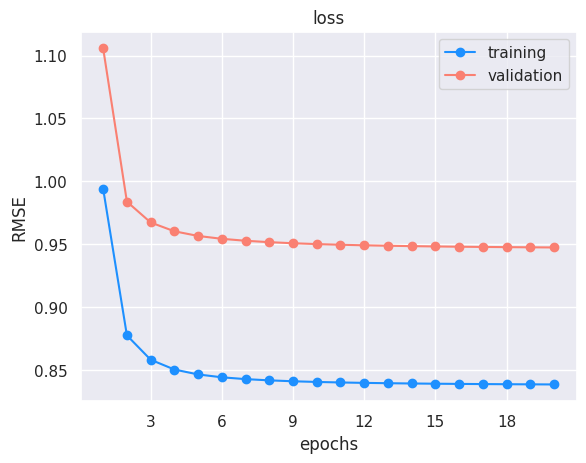

In [45]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

sns.set()
iterations = np.arange(1, epochs + 1, 1)

ax = plt.figure().gca()
plt.title("loss")
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.plot(iterations, train_rmse, "-o", color="dodgerblue", label="training")
plt.plot(iterations, valid_rmse, "-o", color="salmon", label="validation")
plt.legend(loc="best")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))


The baseline RMSE Netflix had achieved before the competition was `0.95` so this get's close to that but has a lot of room for improvement.  Several things that could improve are:

- tune the lambda regularization coefficient
- use adaptive covariance
- separate covariance for users and movies
- use a diagonal covariance matrix (instead of spherical) to account for different variation between latent features